# 0. Setup

## 0.1 Import Libraries

In [44]:
import requests
import urllib.parse
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## 0.2 Define Variables

In [45]:
FROST_DATASTREAM = "T@THI.FE.005"
FROST_TIME_START = "2024-07-01T00:00:00+01:00"
FROST_TIME_END = "2024-07-15T12:00:00+01:00"
FROST_DATASTREAM_QUERY = f'Datastreams?$filter=substringof(%27{FROST_DATASTREAM}%27,name)'
FROST_URL = "https://kdp-ediaqi.know-center.at/FROST-Server/v1.1/"
AUTHENTICATION_URL = "https://kdp-ediaqi.know-center.at/keycloak/realms/master/protocol/openid-connect/token"
AUTHENTICATION_DETAILS = {
    'client_id': "frost",
    'username': "x",
    'password': "x",
    'grant_type': 'password',
}

## 0.3 Define Authentication Function

In [46]:
def get_access_token():
    response = requests.post(AUTHENTICATION_URL, data=AUTHENTICATION_DETAILS)
    response.raise_for_status()  # Raise an exception for HTTP errors
    token_response = response.json()
    return token_response['access_token']

## 0.4 Define Download Function

In [47]:
def get_frost_data(url_to_request, access_token):
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    response = requests.get(url_to_request, headers=headers, verify=False)
    if response.status_code == 200:
        # The request was successful
        data = response.json()  # Assuming the response is in JSON format
        return data
    else:
        # There was an error with the request
        print(f"Error {response.status_code}: {response.text}")
        print("------")
        return 0

# 1. Dowload the Data

In [52]:
access_token = get_access_token()
data_stream = get_frost_data(FROST_URL+FROST_DATASTREAM_QUERY, access_token)["value"][0]
observations_link = data_stream["Observations@iot.navigationLink"] +\
                                "?$filter=phenomenonTime ge " + urllib.parse.quote_plus(FROST_TIME_START) +\
                                " and phenomenonTime le " + urllib.parse.quote_plus(FROST_TIME_END)
observations = get_frost_data(observations_link, access_token)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kdp-ediaqi.know-center.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kdp-ediaqi.know-center.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# 2. Transform Data into Pandas DataFrame

In [54]:
df = pd.DataFrame(observations["value"])
df = df[['@iot.id', 'phenomenonTime', 'result']]
df.columns = ['id', 'phenomenonTime', 'result']

df['start_time'] = df['phenomenonTime'].apply(lambda x: x.split('/')[0])
df['start_time'] = pd.to_datetime(df['start_time'])

# 3. Plotting

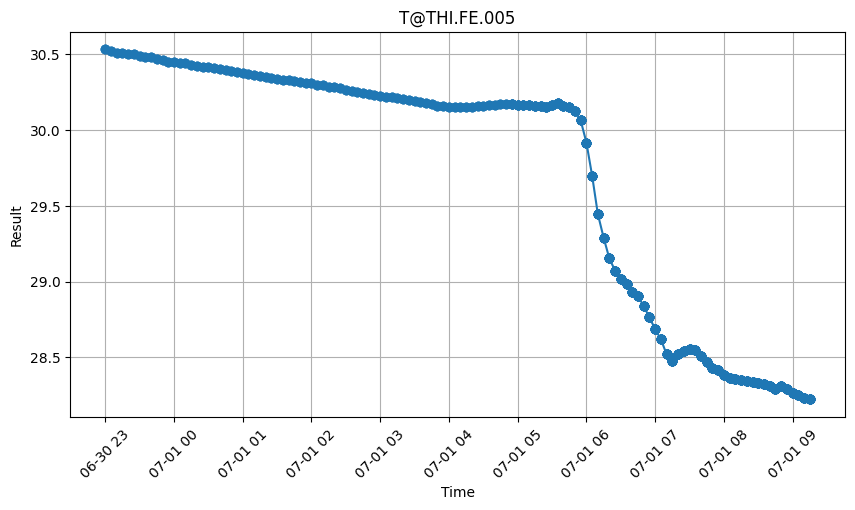

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(df['start_time'], df['result'], marker='o')

plt.xlabel('Time')
plt.ylabel('Result')
plt.title( FROST_DATASTREAM )
plt.grid(True)
plt.xticks(rotation=45)

plt.show()